# Default training Parameters:

In [1]:
from RLTrain import Opt
import os
import time
print(Opt())

policy                        			MlpPolicy
algorithm                     			PPO
environment                   			WurtzReact-v1
steps                         			500
dir                           			<DEFAULT>
seed                          			None



# Training an agent with default parameters

In [2]:
t=time.time()
os.system("python RLTrain.py steps=30000")
print(time.time()-t)

788.6147751808167


# Running inference with the trained models and saving [S,A,R,S] info

In [3]:
os.system("python RLTest.py PPO_WurtzReact-v1 steps=500")
os.system("python RLTest.py WRH algorithm=WRH steps=500")

0

# Gathering some Heuristics

In [1]:
import pandas as pd
ppo = pd.read_pickle("PPO_WurtzReact-v1/rollout")
heuristic = pd.read_pickle("WRH/rollout")

info = [
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ],
    ('PPO', [
        [a for a in ppo.Action.mean()],
        [ppo[ppo.Done==True].Reward.mean()]*6]),
    ('Heuristic', [
        [a for a in heuristic.Action.mean()],
        [heuristic[heuristic.Done==True].Reward.mean()]*6]),

]

# Plot as a Radar Graph

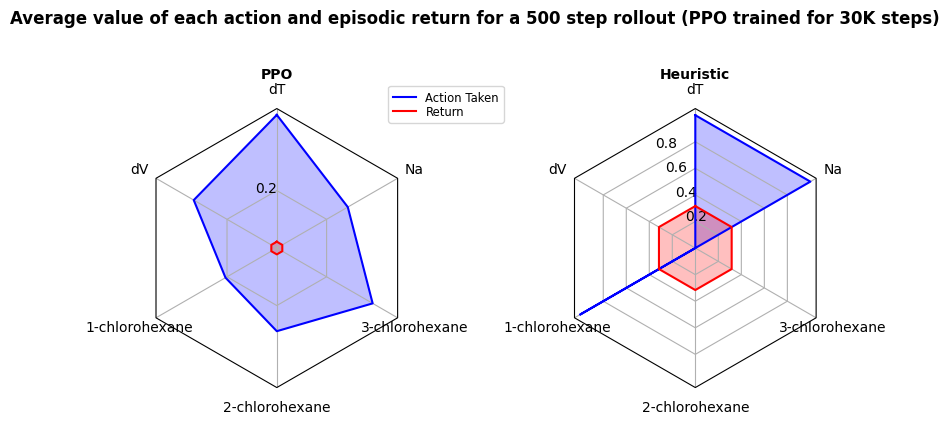

In [11]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')


fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info)

labels = ('Action Taken', 'Return', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.7, "Average value of each action and episodic return for a 500 step rollout (PPO trained for 30K steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()